In [0]:
import matplotlib.pyplot as plt

%matplotlib inline

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from keras.engine.base_layer import Layer
from keras.layers import Activation, Dense
from keras import backend as K
from sklearn.model_selection import train_test_split
from keras.datasets import mnist
from keras.optimizers import SGD
from keras.utils import np_utils
from __future__ import print_function
import keras
from keras.models import Sequential
from keras.layers.core import Flatten
from keras.layers import Dropout
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
import numpy as np


class Mish(Layer):
    """
    Mish Activation Function.
    .. math::
        mish(x) = x * tanh(softplus(x)) = x * tanh(ln(1 + e^{x}))
    Shape:
        - Input: Arbitrary. Use the keyword argument `input_shape`
        (tuple of integers, does not include the samples axis)
        when using this layer as the first layer in a model.
        - Output: Same shape as the input.
    Examples:
        >>> X_input = Input(input_shape)
        >>> X = Mish()(X_input)
    """

    def __init__(self, **kwargs):
        super(Mish, self).__init__(**kwargs)
        self.supports_masking = True

    def call(self, inputs):
        return inputs * K.tanh(K.softplus(inputs))

    def get_config(self):
        base_config = super(Mish, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    def compute_output_shape(self, input_shape):
        return input_shape

In [0]:
def mish(x):
    return keras.layers.Lambda(lambda x: x * K.tanh(K.softplus(x)))(x)

In [29]:
batch_size = 128
num_classes = 10
epochs = 10

# input image dimensions
img_rows, img_cols = 28, 28

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

if K.image_data_format() == "channels_first":
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype("float32")
x_test = x_test.astype("float32")
x_train /= 255
x_test /= 255
print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)


def model_relu(num_layers, x_train, y_train, batch_size, epochs, x_test, y_test):
    model = Sequential()
    model.add(Conv2D(20, kernel_size=(5, 5), activation=mish, input_shape=input_shape))
    model.add(Conv2D(50, (5, 5), activation=mish))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    for layers in range(num_layers):
        model.add(Dense(500))
        model.add(BatchNormalization())
        model.add(Mish())
        model.add(Dropout(0.25))
    model.add(Dense(num_classes, activation="softmax"))

    model.compile(
        loss=keras.losses.categorical_crossentropy,
        optimizer=keras.optimizers.SGD(),
        metrics=["accuracy"],
    )

    model.fit(
        x_train,
        y_train,
        batch_size=batch_size,
        epochs=epochs,
        verbose=1,
        validation_data=(x_test, y_test),
    )
    score = model.evaluate(x_test, y_test, verbose=0)
    return score[1]


l1 = []
for x in range(12, 23):
    test_acc = model_relu(x, x_train, y_train, batch_size, epochs, x_test, y_test)
    l1.append(test_acc)

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples
Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 61s 1ms/step - loss: 1.5130 - acc: 0.4793 - val_loss: 0.4878 - val_acc: 0.8594
Epoch 2/10
60000/60000 [==============================] - 28s 471us/step - loss: 0.5191 - acc: 0.8393 - val_loss: 0.2602 - val_acc: 0.9230
Epoch 3/10
60000/60000 [==============================] - 29s 477us/step - loss: 0.3460 - acc: 0.8968 - val_loss: 0.1868 - val_acc: 0.9442
Epoch 4/10
60000/60000 [==============================] - 28s 468us/step - loss: 0.2674 - acc: 0.9204 - val_loss: 0.1227 - val_acc: 0.9631
Epoch 5/10
60000/60000 [==============================] - 28s 468us/step - loss: 0.2164 - acc: 0.9378 - val_loss: 0.1030 - val_acc: 0.9672
Epoch 6/10
60000/60000 [==============================] - 28s 466us/step - loss: 0.1858 - acc: 0.9464 - val_loss: 0.0852 - val_acc: 0.9746
Epoch 7/10
60000/60000 [=====================

In [0]:
l2 = [
    0.982,
    0.9791,
    0.9795,
    0.9752,
    0.972,
    0.9622,
    0.9557,
    0.9174,
    0.7358,
    0.6341,
    0.3968,
]
l2 = [i * 100 for i in l2]

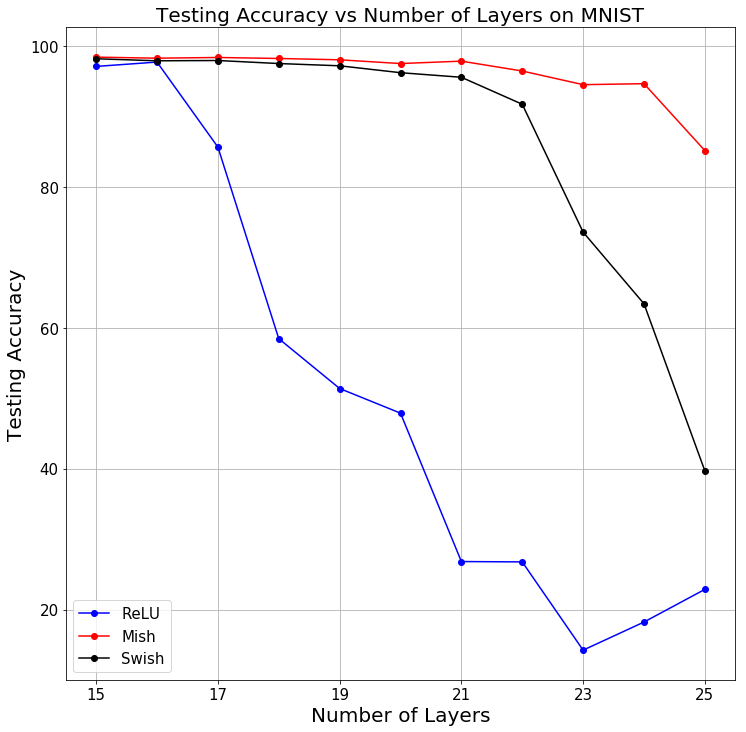

In [63]:
positions = (0, 2, 4, 6, 8, 10)
labels = (15, 17, 19, 21, 23, 25)

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111)
plt.plot(l, "b-o", label="ReLU")
plt.plot(l1, "r-o", label="Mish")
plt.plot(l2, "k-o", label="Swish")
plt.legend(loc="best", fontsize=15)
plt.xticks(positions, labels)
plt.grid()
plt.xlabel("Number of Layers", fontsize=20)
plt.ylabel("Testing Accuracy", fontsize=20)
ax.tick_params(axis="both", which="major", labelsize=15)
ax.title.set_text("Testing Accuracy vs Number of Layers on MNIST")
ax.title.set_fontsize(20)
plt.savefig("layersacc.png", bbox_inches="tight")
plt.show()